In [1]:
import os
import json

import pandas as pd

In [2]:
"""
Get the lit of classes present in the dataset.
"""
# https://www.kaggle.com/datasets/mittalshubham/images256
dat_dir = r"/Users/anandkrishnakumar/Downloads/scenes_dataset"

classes = []
for dir in os.listdir(dat_dir):
    if dir not in ['.DS_Store', 'files.csv']:
        classes.extend(os.listdir(os.path.join(dat_dir, dir)))

classes = sorted(set(classes))
classes.remove('.DS_Store')

In [ ]:
"""
Assign vibe priors to each scene class. Then assign that to each image in the dataset.
"""

with open("vibe_priors_by_scene_class.json", "r") as f:
    vibe_priors = json.load(f)

vibe_dict = {entry["scene_class"]: entry for entry in vibe_priors}

def label_images_in_dataset(dataset_dir):
    labeled_data = []
    for letter in os.listdir(dataset_dir):
        if letter in ['.DS_Store', 'files.csv']:
            continue
        for scene_class in os.listdir(os.path.join(dataset_dir, letter)):
            if scene_class in ['.DS_Store', 'files.csv']:
                continue
            class_path = os.path.join(dataset_dir, letter, scene_class)
            if not os.path.isdir(class_path) or scene_class not in vibe_dict:
                continue
            for filename in os.listdir(class_path):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_id = f"{scene_class}/{filename}"
                    labeled_data.append({
                        "id": image_id,
                        "vibe": {k: v for k, v in vibe_dict[scene_class].items() if k != "scene_class"}
                    })
    return labeled_data

labeled = label_images_in_dataset(dat_dir)
# with open("labeled_data.json", "w") as f:
#     json.dump(labeled, f, indent=2)


In [ ]:
"""
Create a table with the labeled data.
This table will have the columns: id, danceability, energy, ...
"""

dataset = pd.DataFrame(labeled)

# Expand the 'vibe' column into separate columns
vibe_columns = pd.json_normalize(dataset['vibe'])
# Concatenate the vibe columns with the original dataset
dataset = pd.concat([dataset.drop(columns=['vibe']), vibe_columns], axis=1)
# Save the dataset to a CSV file
# dataset.to_csv("labeled_data.csv", index=False)
# Print the first few rows of the dataset
dataset.head()

,id,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo
0,restaurant/gsun_86cbf479c4b4fbd79d08ac10d385f8...,0.5,0.4,0.05,0.5,0.05,0.6,85
1,restaurant/gsun_396d7d2ca2c453fc5743ff893d4efd...,0.5,0.4,0.05,0.5,0.05,0.6,85
2,restaurant/gsun_7d13bbe02ae27c83aedb8bd89b15c1...,0.5,0.4,0.05,0.5,0.05,0.6,85
3,restaurant/gsun_7f121bbd98a8f4852298ef58f02424...,0.5,0.4,0.05,0.5,0.05,0.6,85
4,restaurant/gsun_3977e6d9da189d2a139d33488b9733...,0.5,0.4,0.05,0.5,0.05,0.6,85


In [53]:
num_vibe_attributes = 6
vibe_attributes = dataset.columns[1:num_vibe_attributes + 1].tolist()

vibe_attributes

['danceability',
 'energy',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'valence']

### Training a CNN

In [ ]:
# Call the model on a sample image

from PIL import Image
from torchvision import transforms, models
import torch
from torch import nn

transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

# change final layer for transfer learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_vibe_attributes),
    # nn.Linear(256, 1),
    nn.Sigmoid()
)

/Users/anandkrishnakumar/Coding/vibecon/api/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/anandkrishnakumar/Coding/vibecon/api/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
def load_data(dataset_dir, dataset, max_samples=1):
    X_train = []
    y_train = []

    for i, row in dataset.iterrows():
        if i >= max_samples:
            break

        image_path = os.path.join(dataset_dir, row['id'][0], row['id'])

        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)

        vibe_values = row[vibe_attributes].values.tolist()

        X_train.append(image_tensor)
        y_train.append(torch.tensor(vibe_values, dtype=torch.float32))

        if (i + 1) % 100 == 0:
            print(f"Loaded {i+1} images...")


    return torch.stack(X_train), torch.stack(y_train)

# shuffle dataset
dataset_shuffled = dataset.sample(frac=1).reset_index(drop=True)

X, y = load_data(dat_dir, dataset_shuffled, max_samples=1000)

# Test fraction
test_fraction = 0.2
# Split the dataset into training and testing sets
test_size = int(len(X) * test_fraction)
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]
# Print the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Loaded 100 images...
Loaded 200 images...
Loaded 300 images...
Loaded 400 images...
Loaded 500 images...
Loaded 600 images...
Loaded 700 images...
Loaded 800 images...
Loaded 900 images...
Loaded 1000 images...
Training set shape: torch.Size([800, 3, 224, 224]), torch.Size([800, 6])
Testing set shape: torch.Size([200, 3, 224, 224]), torch.Size([200, 6])


In [59]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
print(f"Using device: {device}")

Using device: cpu


In [60]:
# training
num_epochs = 7
train_losses = []

print("Starting training...")
resnet50.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = resnet50(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        num_batches += 1
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')
    
    # Calculate average loss for this epoch
    avg_loss = running_loss / num_batches
    train_losses.append(avg_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.6f}')
    print('-' * 50)

print("Training completed!")

Starting training...
Epoch 1/10, Batch 0, Loss: 0.077468
Epoch 1/10, Batch 10, Loss: 0.027304
Epoch 1/10, Batch 20, Loss: 0.017822
Epoch 1/10 - Average Loss: 0.027673
--------------------------------------------------
Epoch 2/10, Batch 0, Loss: 0.016945
Epoch 2/10, Batch 10, Loss: 0.017585
Epoch 2/10, Batch 20, Loss: 0.011426
Epoch 2/10 - Average Loss: 0.013625
--------------------------------------------------
Epoch 3/10, Batch 0, Loss: 0.010745
Epoch 3/10, Batch 10, Loss: 0.009320
Epoch 3/10, Batch 20, Loss: 0.012551
Epoch 3/10 - Average Loss: 0.011674
--------------------------------------------------
Epoch 4/10, Batch 0, Loss: 0.010159
Epoch 4/10, Batch 10, Loss: 0.013404
Epoch 4/10, Batch 20, Loss: 0.011182
Epoch 4/10 - Average Loss: 0.011021
--------------------------------------------------
Epoch 5/10, Batch 0, Loss: 0.007386
Epoch 5/10, Batch 10, Loss: 0.011199
Epoch 5/10, Batch 20, Loss: 0.008955
Epoch 5/10 - Average Loss: 0.010106
---------------------------------------------

In [65]:
# Test model
resnet50.eval()

with torch.no_grad():
    X_test = X_test.to(device)
    predictions = resnet50(X_test)
    predictions = predictions.cpu()
    y_test = y_test.cpu()

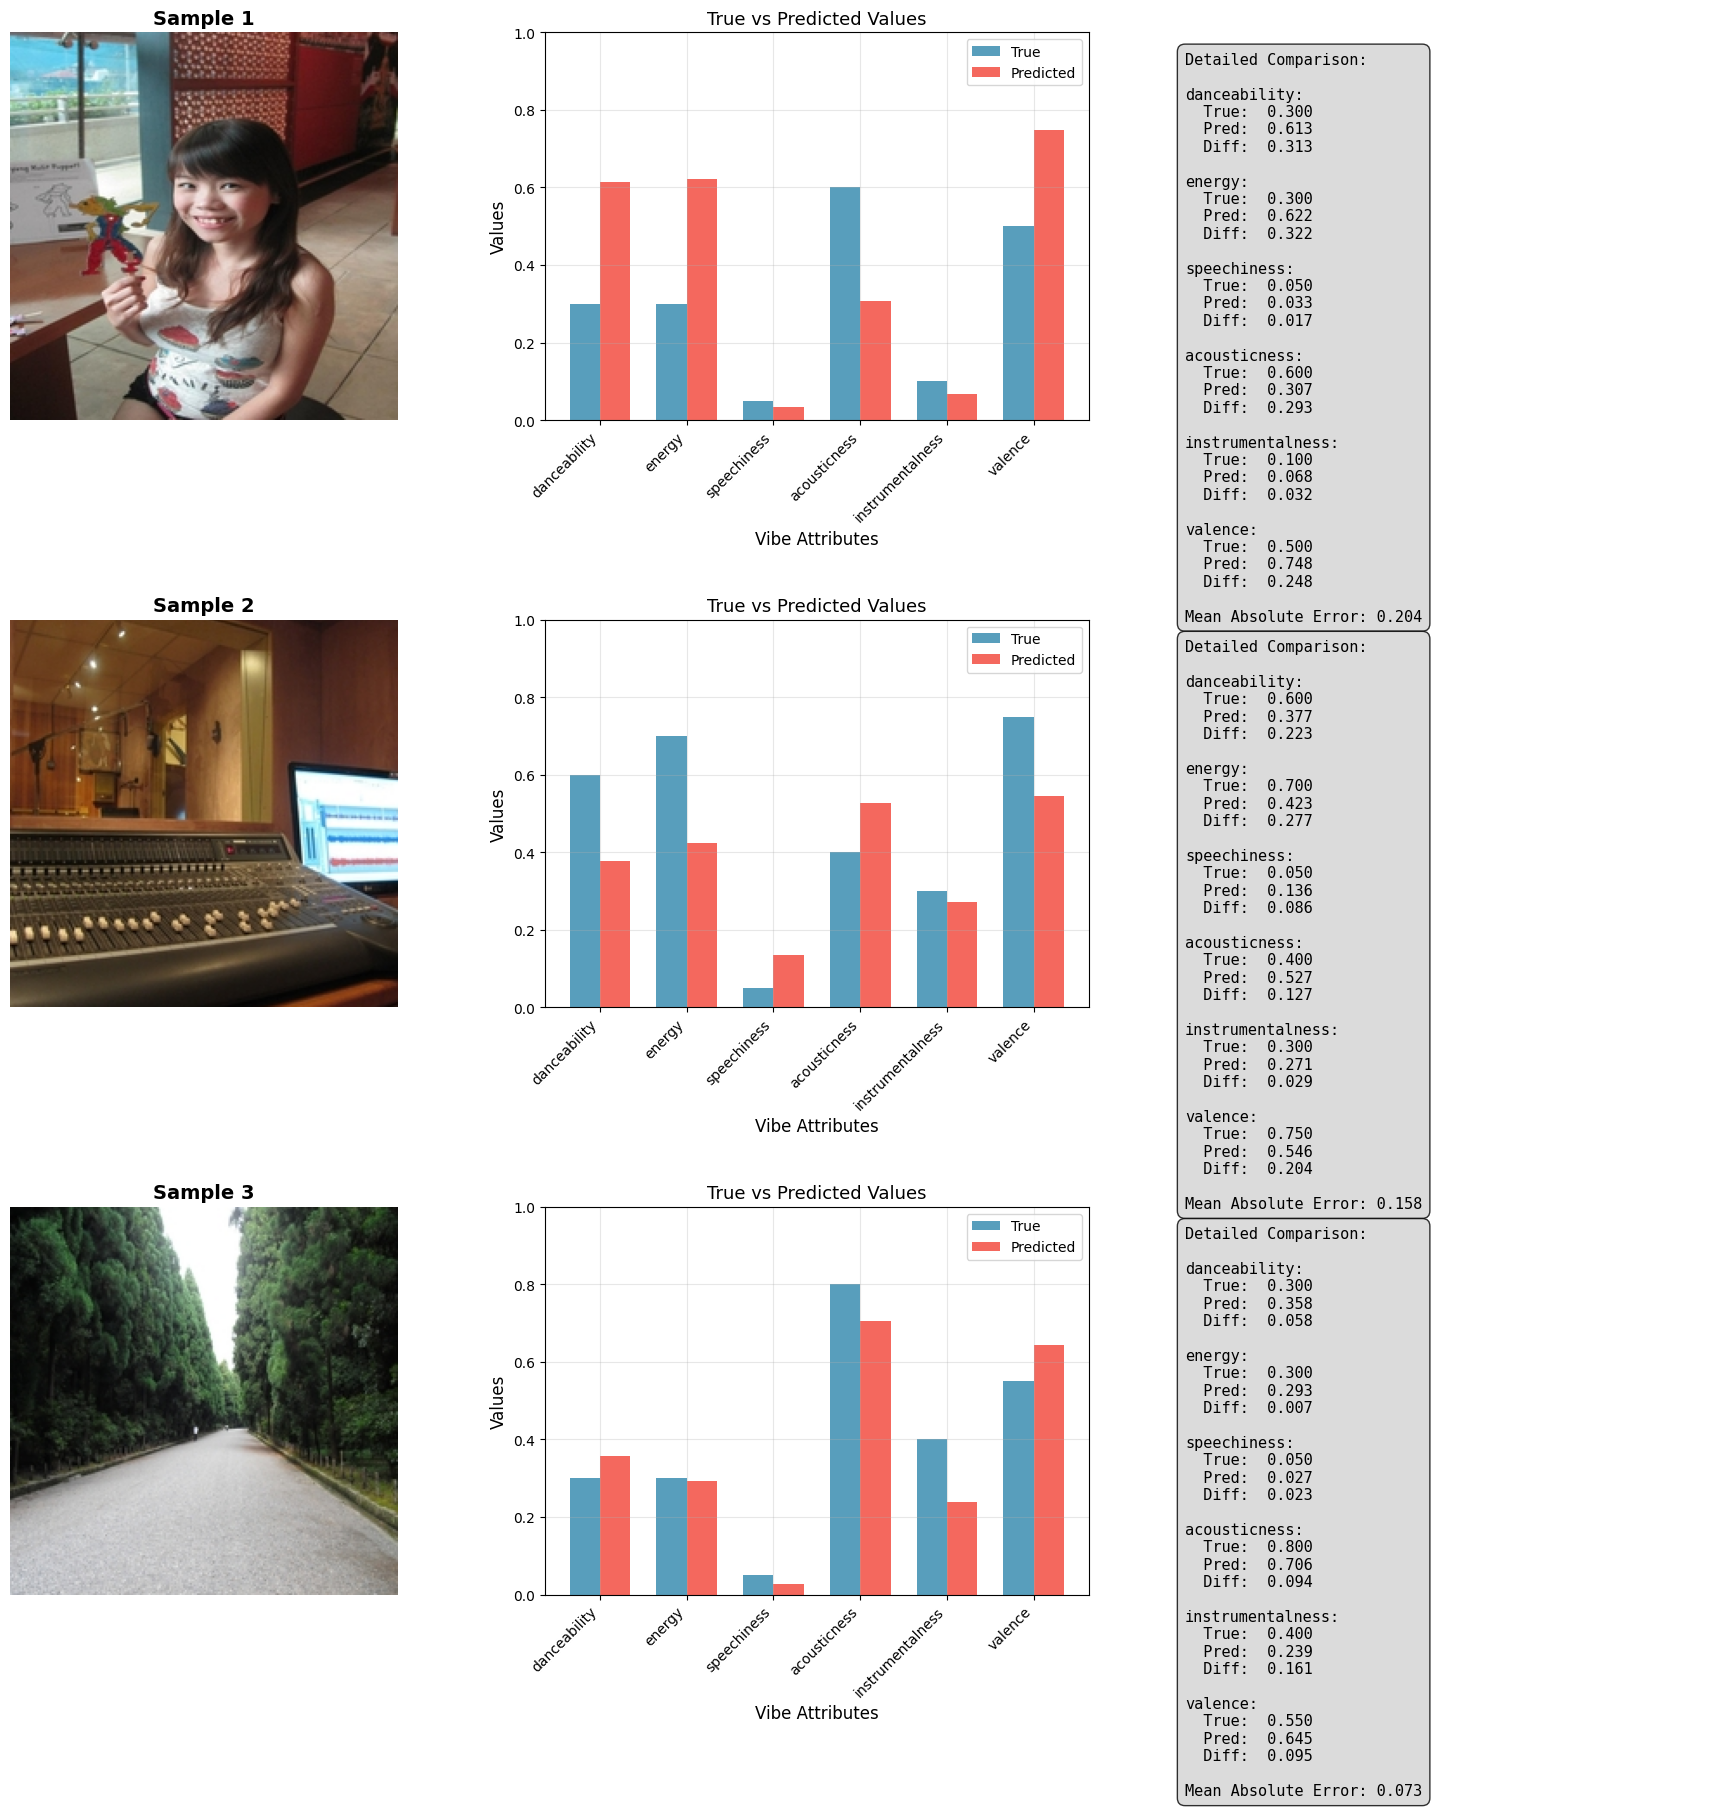

In [70]:
# Much better visualization function
import matplotlib.pyplot as plt
import numpy as np

def display_samples_better(X, y_true, y_pred, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6*num_samples))
    
    # ImageNet normalization values used in transform
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for i in range(num_samples):
        # Column 1: Original Image
        ax_img = axes[i, 0] if num_samples > 1 else axes[0]
        
        # Denormalize the image properly
        img = X[i].clone()
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)  # Reverse normalization
        
        # Clamp and convert to numpy
        img = torch.clamp(img, 0, 1)
        img_np = img.permute(1, 2, 0).numpy()
        
        ax_img.imshow(img_np)
        ax_img.axis('off')
        ax_img.set_title(f'Sample {i+1}', fontsize=14, fontweight='bold')
        
        # Column 2: Bar Chart Comparison
        ax_bar = axes[i, 1] if num_samples > 1 else axes[1]
        
        true_values = y_true[i].numpy()
        pred_values = y_pred[i].numpy()
        
        x_pos = np.arange(len(vibe_attributes))
        width = 0.35
        
        bars1 = ax_bar.bar(x_pos - width/2, true_values, width, 
                          label='True', color='#2E86AB', alpha=0.8)
        bars2 = ax_bar.bar(x_pos + width/2, pred_values, width, 
                          label='Predicted', color='#F24236', alpha=0.8)
        
        ax_bar.set_xlabel('Vibe Attributes', fontsize=12)
        ax_bar.set_ylabel('Values', fontsize=12)
        ax_bar.set_title('True vs Predicted Values', fontsize=13)
        ax_bar.set_xticks(x_pos)
        ax_bar.set_xticklabels(vibe_attributes, rotation=45, ha='right')
        ax_bar.legend()
        ax_bar.set_ylim(0, 1)
        ax_bar.grid(True, alpha=0.3)
        
        # Column 3: Detailed Text Comparison
        ax_text = axes[i, 2] if num_samples > 1 else axes[2]
        ax_text.axis('off')
        
        text_content = "Detailed Comparison:\n\n"
        for j, attr in enumerate(vibe_attributes):
            true_val = true_values[j]
            pred_val = pred_values[j]
            diff = abs(true_val - pred_val)
            
            text_content += f"{attr}:\n"
            text_content += f"  True:  {true_val:.3f}\n"
            text_content += f"  Pred:  {pred_val:.3f}\n"
            text_content += f"  Diff:  {diff:.3f}\n\n"
        
        # Calculate overall accuracy
        mae = np.mean(np.abs(true_values - pred_values))
        text_content += f"Mean Absolute Error: {mae:.3f}"
        
        ax_text.text(0.05, 0.95, text_content, 
                    transform=ax_text.transAxes, 
                    fontsize=11, 
                    verticalalignment='top',
                    fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Use the better visualization
display_samples_better(X_test, y_test, predictions, num_samples=3)

In [72]:
# Save the model
save_path = "saved_models/resnet50_vibe_model.pth"
torch.save(resnet50, save_path)